# Signal classification strategy EDA


To install conda and binance packages to this notebook uncomment the code below

In [1]:
#%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
# %pip install plotly==5.9.0
# %pip install twisted
# %pip install binance-connector==1.13.0
#%pip install pandas
#%pip install scikit-learn==1.7.0
# %pip install boto3
#%pip install python-dotenv
#%pip install ta

import os
import sys

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
sys.path.append("pytrade2/pytrade2")
# Read .env variable with s3 access keys
#%load_ext dotenv
#%dotenv

## App parameters

In [2]:
# env file
#env_file='local.env'
env_file='.env'
from dotenv import load_dotenv
dotenv_path = os.path.abspath(env_file) #travels up a level to find the .env
load_dotenv(dotenv_path)

ticker="BTC-USDT"
# Preprocess raw data
data_dir_root = "./data"
data_dir_raw = f"{data_dir_root}/raw"
data_dir_preproc = f"{data_dir_root}/preproc"

#history_days = 100
# Candles or level2 for 04.03 is bad
history_days=40


# The best 07.09.2025 BTC-USDT, 30 days history, 7 test
# profit mean 106, median 182

# The best 19.05.2025 BTC-USDT, 35 days history, 7 test
# profit mean 157, median 219
# profit/drawdown 76

# profit/drawdown 4.5
# profit trades: 16, loss trades: 19 per 7 days
# features_candles_periods = ["10min", "15min", "25min", "40min", "50min", "60min"]
# features_level2_periods = ["10min", "15min", "25min",  "40min", "50min", "60min"]
# target_period='15min'
# profit_loss_ratio = 3

features_candles_periods = ["10min", "15min", "25min", "40min", "50min", "60min"]
features_level2_periods = ["10min", "15min", "25min",  "40min", "50min", "60min"]
# Max period in indicators multiply max indicator aggregation count (53 in ichimoku)
min_history_window_minutes = 60 * 53
min_history_window = pd.Timedelta(minutes = min_history_window_minutes)


target_period='15min'
profit_loss_ratio = 2.5

# 100 
stop_loss_coeff = 0.00100
stop_loss_add_ratio = 0



#test_days = 15
test_days = 7

# For BTC/USDT=100K, comission = 100K * 0.012% = 1K * 0.012 = 12. For open/close comission = 24
comission_pct = 0.012
price_precision = 2
#is_trailing_stop = False
comission = 0.01 * comission_pct
#lgb_params = {'learning_rate':0.1, 'num_iterations': 100}
lgb_params = {'learning_rate':0.1, 'num_iterations': 100}


# lgb_params = {
#         #"n_estimators": 1000,
#         # "max_depth": 6,
#         # "min_samples_split": 10,
#         # "min_samples_leaf": 4,
#         # "bootstrap": True,
#         # "oob_score": False,
#         # "random_state": 888,
    
#     'learning_rate':0.1, 'num_iterations': 150}


experiment_name = 'SignalClassification'
run_name =  f'{experiment_name} target: {target_period}, sharp: {profit_loss_ratio}, periods:{features_candles_periods},  history {history_days}, test {test_days}, stop loss coeff {stop_loss_coeff}'
is_trade_ready = True



## Feature engineering
Read data from bot's history, resample to equal intervals, create X, y

### Read level2, bid/ask, candles data from history

### Preprocess data if configured

In [3]:
# import pathlib

# from features.level2.Level2Features import Level2Features
import numpy as np
from tools.PreprocTool import PreprocTool

preprocTool = PreprocTool(data_dir_root)
preprocTool.preprocess_last_raw_data(ticker, kind = "level2", days = history_days, transform_func = PreprocTool.level2_transform)
preprocTool.preprocess_last_raw_data(ticker, kind = "bid_ask", days = history_days)
preprocTool.preprocess_last_raw_data(ticker, kind = "candles", days = history_days, datetime_col = "close_time", agg = {"open_time" : "last", "close_time": "last", "open": "first", "high": "max", "low": "min", "close": "last", "vol": "sum"})


No new raw data appeared after 2025-05-20_BTC-USDT_level2.csv.zip
Preprocess 0 new level2 raw files
No new raw data appeared after 2025-05-20_BTC-USDT_bid_ask.csv.zip
Preprocess 0 new bid_ask raw files
No new raw data appeared after 2025-05-20_BTC-USDT_candles.csv.zip
Preprocess 0 new candles raw files


### Read preprocessed bid/ask, level2, candles

In [4]:
df_bid_ask = preprocTool.read_last_preproc_data(ticker, "bid_ask", days = history_days)
df_bid_ask.tail()

Read BTC-USDT bid_ask data for 40 days from ./data/preproc/bid_ask


datetime            bid      bid_vol            ask      ask_vol
datetime                                                                                       
2025-05-20 06:57:00 2025-05-20 06:57:00  105508.864489  7928.635417  105509.011648   715.604167
2025-05-20 06:58:00 2025-05-20 06:58:00  105512.927523  4141.204893  105513.069266  5038.825688
2025-05-20 06:59:00 2025-05-20 06:59:00  105495.185861  2264.705656  105495.680334  4790.210797
2025-05-20 07:00:00 2025-05-20 07:00:00  105432.586438  3711.552906  105432.878689  5770.513413
2025-05-20 07:01:00 2025-05-20 07:01:00  105427.077379  8364.620905  105427.282527  1231.998440

In [5]:
df_candles_1min = preprocTool.read_last_preproc_data(ticker, "candles", datetime_col = "close_time", days = history_days)
df_candles_1min.tail()

Read BTC-USDT candles data for 40 days from ./data/preproc/candles


/home/dima/projects/pytrade2-analytics/tools/PreprocTool.py:117: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[x['vol'] == x['vol'].max()]) \


close_time            open_time      open      high       low     close    vol
close_time                                                                                                 
2025-05-20 06:56:00 2025-05-20 06:56:00  2025-05-20 06:55:00  105492.6  105518.5  105492.6  105518.5  69804
2025-05-20 06:57:00 2025-05-20 06:57:00  2025-05-20 06:56:00  105518.5  105518.5  105511.4  105511.5  13080
2025-05-20 06:58:00 2025-05-20 06:58:00  2025-05-20 06:57:00  105511.5  105511.5  105460.5  105460.6  38004
2025-05-20 06:59:00 2025-05-20 06:59:00  2025-05-20 06:58:00  105460.6  105460.6  105420.0  105420.0  49590
2025-05-20 07:00:00 2025-05-20 07:00:00  2025-05-20 06:59:00  105420.0  105441.6  105420.0  105441.6   6854

In [6]:
df_level2 = preprocTool.read_last_preproc_data(ticker, "level2", days = history_days)
df_level2.tail()

Read BTC-USDT level2 data for 40 days from ./data/preproc/level2


datetime     l2_bid_max     l2_bid_vol  l2_bid_expect     l2_ask_min     l2_ask_vol  l2_ask_expect  l2_bid_ask_expect  l2_bid_ask_vol
datetime                                                                                                                                                            
2025-05-20 06:57:00 2025-05-20 06:57:00  105502.700000  148892.258333  105436.664790  105512.700000  110107.470000  105598.102516      105505.269148   258999.728333
2025-05-20 06:58:00 2025-05-20 06:58:00  105510.000000  126717.236181  105421.707744  105520.000000  133348.973199  105596.230974      105511.383161   260066.209380
2025-05-20 06:59:00 2025-05-20 06:59:00  105494.850000  123556.371667  105404.282236  105504.850000  141476.136667  105577.714288      105496.973269   265032.508333
2025-05-20 07:00:00 2025-05-20 07:00:00  105429.766667  125359.010000  105334.558468  105439.766667  130378.050000  105510.270689      105424.209732   255737.060000
2025-05-20 07:01:00 2025-05-20 07:01:00  105423.695652  133476.798913  105347.119340  105433.695652  103713.923913  105516.971241      105421.438113   237190.722826

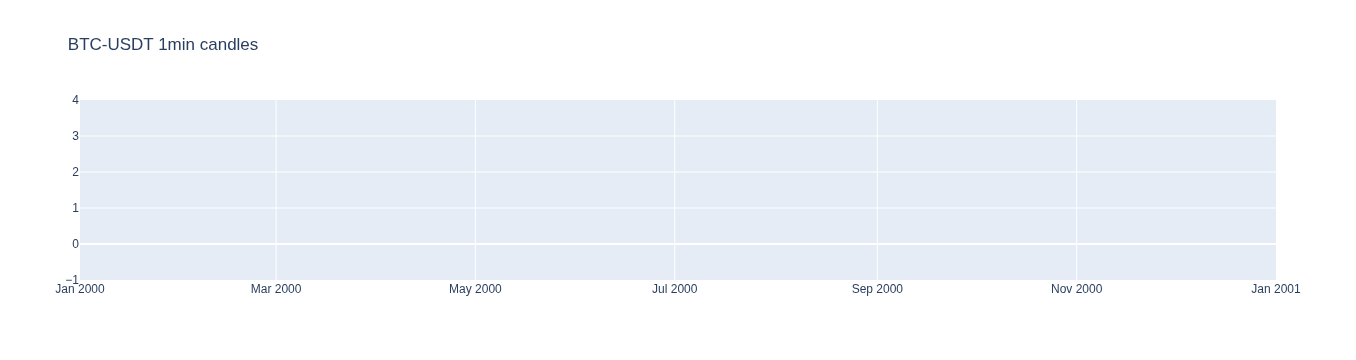

In [7]:
from tools.PlotTool import PlotTool
df_candles_1min["ticker"] = ticker
PlotTool.plot_candles(df_candles_1min.tail(100), '1min')

In [8]:
df_level2.head()

datetime    l2_bid_max     l2_bid_vol  l2_bid_expect    l2_ask_min     l2_ask_vol  l2_ask_expect  l2_bid_ask_expect  l2_bid_ask_vol
datetime                                                                                                                                                          
2025-04-03 23:58:00 2025-04-03 23:58:00  83100.839161  191134.423077   82999.927707  83110.839161  163966.038462   83203.994945       83094.140333   355100.461538
2025-04-03 23:59:00 2025-04-03 23:59:00  83100.000000  207615.930000   82996.191521  83110.000000  152148.910000   83197.375320       83081.584370   359764.840000
2025-04-04 00:00:00 2025-04-04 00:00:00  83111.235392  156550.904841   83009.980036  83121.268781  118726.522538   83212.496186       83099.083858   275277.427379
2025-04-04 00:01:00 2025-04-04 00:01:00  83182.988314  115180.637730   83086.637791  83192.988314   86209.003339   83285.351633       83173.289079   201389.641068
2025-04-04 00:02:00 2025-04-04 00:02:00  83229.600000  156029.895000   83136.572104  83239.600000  163010.668333   83336.718819       83238.809712   319040.563333

### Build features and targets

Prepare Level 2 features

In [9]:
from ta import trend, momentum
from features.MultiIndiFeatures import MultiIndiFeatures

def level2_ichimoku_of(df_level2: pd.DataFrame, period: str = '', window1=9, window2=26, window3=52):
    df = pd.DataFrame()
    ichimoku = trend.IchimokuIndicator(df_level2['l2_ask_expect'], df_level2['l2_bid_expect'],
                                       window1=window1, window2=window2, window3=window3, fillna=False)
    df[f'l2_ichimoku_base_line_{period}_diff'] = ichimoku.ichimoku_base_line().diff()
    df[f'l2_ichimoku_conversion_line_{period}_diff'] = ichimoku.ichimoku_conversion_line().diff()
    df[f'l2_ichimoku_a_{period}_diff'] = ichimoku.ichimoku_a().diff()
    df[f'l2_ichimoku_b_{period}_diff'] = ichimoku.ichimoku_b().diff()
    # df[f'l2_ichimoku_base_line_{period}'] = ichimoku.ichimoku_base_line()
    # df[f'l2_ichimoku_conversion_line_{period}'] = ichimoku.ichimoku_conversion_line()
    # df[f'l2_ichimoku_a_{period}'] = ichimoku.ichimoku_a()
    # df[f'l2_ichimoku_b_{period}'] = ichimoku.ichimoku_b()
    return df


def rolling_level2(df_level2, window):
    """ Unlike resample, rolling window does not work with first, last aggregations and with datetime there.
        Some hacks needed """
    df = df_level2.copy()
    # Convert datetime to numeric because rolling window does not work with times for getting first in aggregation
    df['datetime'] = pd.to_datetime(df['datetime']).astype('int64')
    # Aggregate
    df = df.rolling(window, closed = 'right').mean()
    df['datetime'] = pd.to_datetime(df['datetime'], unit = 'ns') 

    return df  
def level2_indicators_of(df_level2, period, params: dict = None):
    """ Single period indicators"""

    if not params:
        params = MultiIndiFeatures.default_params

    
    resampled = df_level2.resample("1min", closed="right").agg("mean")    
    #resampled = rolling_level2(df_level2, period)
    resampled["l2_price"] = (resampled["l2_bid_max"] + resampled["l2_ask_min"]) / 2
    
    df = level2_ichimoku_of(resampled,
                                       period,
                                       params["ichimoku"]["window1"],
                                       params["ichimoku"]["window2"],
                                       params["ichimoku"]["window3"], )
    df[f'l2_cci_{period}_diff'] = trend.cci(resampled['l2_ask_expect'], resampled['l2_bid_expect'], resampled['l2_price'],
                                         window=params["cca"]["window"], fillna=False).diff()
    df[f'l2_adx_{period}_diff'] = trend.adx(resampled['l2_ask_expect'], resampled['l2_bid_expect'], resampled['l2_price'],
                                         window=params["adx"]["window"], fillna=False).diff()
    df[f'l2_rsi_{period}_diff'] = momentum.rsi(resampled['l2_price'], window=params["rsi"]["window"], fillna=False).diff()
    df[f'l2_stoch_{period}_diff'] = momentum.stoch(resampled['l2_ask_expect'], resampled['l2_bid_expect'], resampled['l2_price'],
                                                window=params["stoch"]["window"],
                                                smooth_window=params["stoch"]["smooth_window"], fillna=False).diff()
    df[f'l2_macd_{period}_diff'] = trend.macd(resampled['l2_price'], window_slow=params["macd"]["slow"],
                                           window_fast=params["macd"]["fast"], fillna=False).diff()

    #df = df.dropna()
    return df

def level2_features_of(df_level2, periods):
    #df = df_level2.copy()
    #del df["datetime"]

    level2_features = None
    for period in periods:
        period_indicators = level2_indicators_of(df_level2, period)
        if level2_features is None:
            level2_features = period_indicators
        else:
            level2_features = pd.merge(
                level2_features,
                period_indicators,
                left_index=True,
                right_index=True,
                how='outer'
        )
    return level2_features.dropna().sort_index()

level2_features = level2_features_of(df_level2, features_level2_periods)
level2_features

l2_ichimoku_base_line_10min_diff  l2_ichimoku_conversion_line_10min_diff  l2_ichimoku_a_10min_diff  l2_ichimoku_b_10min_diff  l2_cci_10min_diff  l2_adx_10min_diff  l2_rsi_10min_diff  l2_stoch_10min_diff  l2_macd_10min_diff  l2_ichimoku_base_line_15min_diff  l2_ichimoku_conversion_line_15min_diff  l2_ichimoku_a_15min_diff  l2_ichimoku_b_15min_diff  l2_cci_15min_diff  l2_adx_15min_diff  l2_rsi_15min_diff  l2_stoch_15min_diff  l2_macd_15min_diff  l2_ichimoku_base_line_25min_diff  l2_ichimoku_conversion_line_25min_diff  l2_ichimoku_a_25min_diff  l2_ichimoku_b_25min_diff  l2_cci_25min_diff  l2_adx_25min_diff  l2_rsi_25min_diff  l2_stoch_25min_diff  l2_macd_25min_diff  l2_ichimoku_base_line_40min_diff  l2_ichimoku_conversion_line_40min_diff  l2_ichimoku_a_40min_diff  l2_ichimoku_b_40min_diff  l2_cci_40min_diff  l2_adx_40min_diff  l2_rsi_40min_diff  l2_stoch_40min_diff  l2_macd_40min_diff  l2_ichimoku_base_line_50min_diff  l2_ichimoku_conversion_line_50min_diff  l2_ichimoku_a_50min_diff  l2_ichimoku_b_50min_diff  l2_cci_50min_diff  l2_adx_50min_diff  l2_rsi_50min_diff  l2_stoch_50min_diff  l2_macd_50min_diff  l2_ichimoku_base_line_60min_diff  l2_ichimoku_conversion_line_60min_diff  l2_ichimoku_a_60min_diff  l2_ichimoku_b_60min_diff  l2_cci_60min_diff  l2_adx_60min_diff  l2_rsi_60min_diff  l2_stoch_60min_diff  l2_macd_60min_diff
datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2025-04-04 00:23:00                          0.000000                                0.000000                  0.000000                       0.0         -13.979950           0.000000          -2.303845            -2.434447            4.435205                          0.000000                                0.000000                  0.000000                       0.0         -13.979950           0.000000          -2.303845            -2.434447            4.435205                          0.000000                                0.000000                  0.000000                       0.0         -13.979950           0.000000          -2.303845            -2.434447            4.435205                          0.000000                                0.000000                  0.000000                       0.0         -13.979950           0.000000          -2.303845            -2.434447            4.435205                          0.000000                                0.000000                  0.000000                       0.0         -13.979950           0.000000          -2.303845            -2.434447            4.435205                          0.000000                                0.000000                  0.000000                       0.0         -13.979950         

The data from exchange can contain gaps. To make our rolling windows correct, 
we need to calculate time gaps and exclude rolling/resamples which cross the gaps.

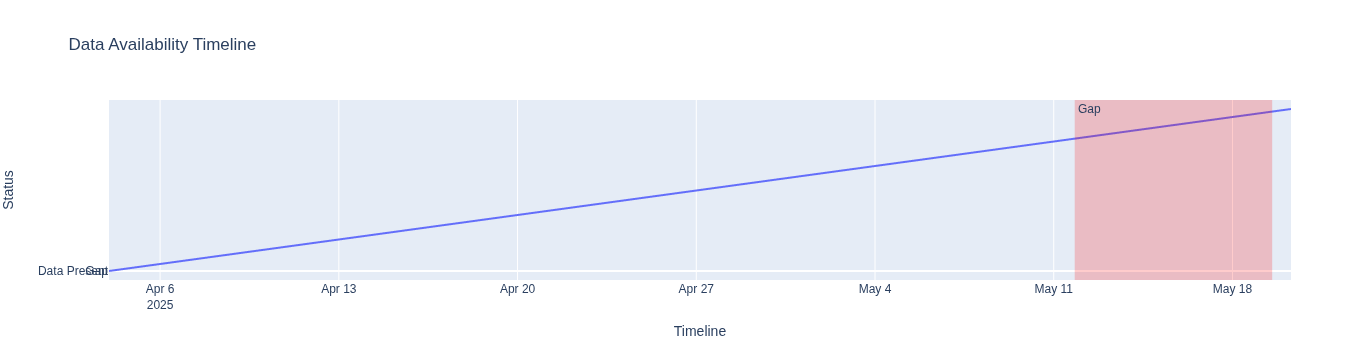

In [10]:
import plotly as py
import plotly.express as px
class FeatureCleaner:
    """ Exclude input time gaps from features"""
    
    def find_time_gaps(self, dfindex:pd.DatetimeIndex, start_delta: pd.Timedelta = pd.Timedelta(0), freq='1min'):
        """
        Find intervals where data is missing in a time series DataFrame.
        
        Parameters:
            df: pandas DataFrame
            time_col: name of the column containing datetime index
            freq: expected frequency of data (default '1min' for minute data)
        
        Returns:
            List of tuples with (gap_start, gap_end) timestamps
        """
        if dfindex.empty: 
            return []
        
        # Generate expected timestamps at the specified frequency
        full_range = pd.date_range(start=dfindex.min(), 
                                   end=dfindex.max(), 
                                   freq=freq)

        # Find missing timestamps
        missing_times = full_range.difference(dfindex)
        
        # Group consecutive missing timestamps into intervals
        gaps = [(dfindex.min(), dfindex.min() + start_delta)]
        if len(missing_times) > 0:
            current_start = missing_times[0]
            prev_time = missing_times[0]
            
            for time in missing_times[1:]:
                if time != prev_time + pd.Timedelta(freq):
                    # Gap ends here
                    gaps.append((current_start, prev_time))
                    current_start = time
                prev_time = time
            
            # Add the last gap
            gaps.append((current_start, prev_time))
        
        return [(start, end + start_delta) for start, end in gaps]

    def get_gap_mask(self, df: pd.DataFrame, gaps: [()]):
        """ Mask time series: True if df record good, bad if in time gap """
        
        intervals = pd.IntervalIndex.from_tuples(
            [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in gaps],
            closed='both'
        )
        
        # Vectorized check for timestamps in gaps
        def is_in_any_gap(ts):
            return any(interval.left <= ts <= interval.right for interval in intervals)
        
        # Create mask (True = gap, False = not in gap)
        return df.index.to_series().apply(is_in_any_gap)       
        
    def exclude_gaps(self, df: pd.DataFrame, gaps:[()]):
        """
        More efficient approach when dealing with many gap intervals.
        df : The input DataFrame containing time series data to be filtered.
        gaps : List of gap intervals as (start_time, end_time) tuples.
        time_col : Name of the column containing the timestamps to check against gaps.
        start_delta: we can start aggregation only after some delta after start to fill the aggregation window
        """
        mask = self.get_gap_mask(df, gaps)
        return df[~mask]
    
    def clean(self, input_df: pd.DataFrame, features_df: pd.DataFrame, start_delta:pd.Timedelta = pd.Timedelta(0)):
        """ Find gaps in input df and exclude bad features inside gaps and before start_delta after each gap """
        gaps = self.find_time_gaps(input_df, start_delta)
        print(f"Found gaps: {gaps}")
        return self.exclude_gaps(features_df, gaps)
    
    def plot_time_gaps(self, df: pd.DataFrame):
        # Create complete 1-minute frequency index
        complete_index = pd.date_range(
            start=df.index.min(),
            end=df.index.max(),
            freq='1min'
        )
        complete_df = pd.DataFrame(index=complete_index)
        has_data_col = "has_data"
        complete_df[has_data_col] = 0
        complete_df.loc[df.index, has_data_col] = 1
        fig = px.line(complete_df, 
                     x=complete_df.index, 
                     y=has_data_col,
                      title='Data Availability Timeline',
                      labels={'is_data': 'Data Present (1=Yes, 0=No)'})
        
        # Customize the appearance
        fig.update_layout(
            yaxis=dict(
                tickmode='array',
                tickvals=[0, 1],
                ticktext=['Gap', 'Data Present']
            ),
            hovermode='x unified',
            xaxis_title='Timeline',
            yaxis_title='Status'
        )
        
        # Highlight gaps with different color
        fig.update_traces(
            line=dict(color='green'),
            selector=dict(name='is_data')  # Only works if you didn't rename in px.line
        )
        
        # Add rectangles for gaps (optional visual enhancement)
        gaps = complete_df[complete_df[has_data_col] == 0]
        if not gaps.empty:
            gap_groups = (gaps.index.to_series().diff() != pd.Timedelta(minutes=1)).cumsum()
            for _, group in gaps.groupby(gap_groups):
                fig.add_vrect(
                    x0=group.index.min(),
                    x1=group.index.max(),
                    fillcolor="red",
                    opacity=0.2,
                    line_width=0,
                    annotation_text="Gap" if (group.index.max() - group.index.min()) > pd.Timedelta(hours=1) else None,
                    annotation_position="top left"
                )
        
        fig.show()
      
        
#FeatureCleaner().clean(df_level2.index, level2_features, min_history_window).info()
#FeatureCleaner().clean(df_level2, level2_features, min_history_window).info()

FeatureCleaner().plot_time_gaps(df_level2)

### All features

In [11]:

sys.path.append("pytrade2/pytrade2")
from pytrade2.pytrade2.features.CandlesFeatures import CandlesFeatures
from pytrade2.pytrade2.features.MultiIndiFeatures import MultiIndiFeatures
from pytrade2.pytrade2.features.LowHighTargets import LowHighTargets
from tools.DataTool import DataTool

feature_cleaner = FeatureCleaner()

# Candles by periods dictionary
candles_by_period = DataTool.candles_by_periods_of(df_candles_1min, features_candles_periods)

# Features
candles_features = MultiIndiFeatures.multi_indi_features(candles_by_period)

#level2_features = level2_features_of(df_level2)
candles_level2_intersection = df_candles_1min.index.intersection(df_level2.index)
features = pd.merge_asof(candles_features, level2_features, left_index = True, right_index=True)
features = feature_cleaner.clean(candles_level2_intersection, features, min_history_window)

targets = LowHighTargets.fut_lohi_signal(df_candles_1min, target_period, stop_loss_coeff, profit_loss_ratio)
targets = feature_cleaner.clean(candles_level2_intersection, targets, min_history_window)

features = features.dropna()
targets = targets.dropna()
features = features[features.index.isin(targets.index)]
targets = targets[targets.index.isin(features.index)]

features.head()


Found gaps: [(Timestamp('2025-04-03 23:58:00'), Timestamp('2025-04-08 09:58:00')), (Timestamp('2025-05-11 19:41:00'), Timestamp('2025-05-21 18:20:00'))]
Found gaps: [(Timestamp('2025-04-03 23:58:00'), Timestamp('2025-04-08 09:58:00')), (Timestamp('2025-05-11 19:41:00'), Timestamp('2025-05-21 18:20:00'))]


time_hour  time_minute  ichimoku_base_line_10min_diff  ichimoku_conversion_line_10min_diff  ichimoku_a_10min_diff  ichimoku_b_10min_diff  cci_10min_diff  adx_10min_diff  rsi_10min_diff  stoch_10min_diff  macd_10min_diff  ichimoku_base_line_15min_diff  ichimoku_conversion_line_15min_diff  ichimoku_a_15min_diff  ichimoku_b_15min_diff  cci_15min_diff  adx_15min_diff  rsi_15min_diff  stoch_15min_diff  macd_15min_diff  ichimoku_base_line_25min_diff  ichimoku_conversion_line_25min_diff  ichimoku_a_25min_diff  ichimoku_b_25min_diff  cci_25min_diff  adx_25min_diff  rsi_25min_diff  stoch_25min_diff  macd_25min_diff  ichimoku_base_line_40min_diff  ichimoku_conversion_line_40min_diff  ichimoku_a_40min_diff  ichimoku_b_40min_diff  cci_40min_diff  adx_40min_diff  rsi_40min_diff  stoch_40min_diff  macd_40min_diff  ichimoku_base_line_50min_diff  ichimoku_conversion_line_50min_diff  ichimoku_a_50min_diff  ichimoku_b_50min_diff  cci_50min_diff  adx_50min_diff  rsi_50min_diff  stoch_50min_diff  macd_50min_diff  ichimoku_base_line_60min_diff  ichimoku_conversion_line_60min_diff  ichimoku_a_60min_diff  ichimoku_b_60min_diff  cci_60min_diff  adx_60min_diff  rsi_60min_diff  stoch_60min_diff  macd_60min_diff  l2_ichimoku_base_line_10min_diff  l2_ichimoku_conversion_line_10min_diff  l2_ichimoku_a_10min_diff  l2_ichimoku_b_10min_diff  l2_cci_10min_diff  l2_adx_10min_diff  l2_rsi_10min_diff  l2_stoch_10min_diff  l2_macd_10min_diff  l2_ichimoku_base_line_15min_diff  l2_ichimoku_conversion_line_15min_diff  l2_ichimoku_a_15min_diff  l2_ichimoku_b_15min_diff  l2_cci_15min_diff  l2_adx_15min_diff  l2_rsi_15min_diff  l2_stoch_15min_diff  l2_macd_15min_diff  l2_ichimoku_base_line_25min_diff  l2_ichimoku_conversion_line_25min_diff  l2_ichimoku_a_25min_diff  l2_ichimoku_b_25min_diff  l2_cci_25min_diff  l2_adx_25min_diff  l2_rsi_25min_diff  l2_stoch_25min_diff  l2_macd_25min_diff  l2_ichimoku_base_line_40min_diff  l2_ichimoku_conversion_line_40min_diff  l2_ichimoku_a_40min_diff  l2_ichimoku_b_40min_diff  l2_cci_40min_diff  l2_adx_40min_diff  l2_rsi_40min_diff  l2_stoch_40min_diff  l2_macd_40min_diff  l2_ichimoku_base_line_50min_diff  l2_ichimoku_conversion_line_50min_diff  l2_ichimoku_a_50min_diff  l2_ichimoku_b_50min_diff  l2_cci_50min_diff  l2_adx_50min_diff  l2_rsi_50min_diff  l2_stoch_50min_diff  l2_macd_50min_diff  l2_ichimoku_base_line_60min_diff  l2_ichimoku_conversion_line_60min_diff  l2_ichimoku_a_60min_diff  l2_ichimoku_b_60min_diff  l2_cci_60min_diff  l2_adx_60min_diff  l2_rsi_60min_diff  l2_stoch_60min_diff  l2_macd_60min_diff
close_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [12]:
candles_features

time_hour  time_minute  ichimoku_base_line_10min_diff  ichimoku_conversion_line_10min_diff  ichimoku_a_10min_diff  ichimoku_b_10min_diff  cci_10min_diff  adx_10min_diff  rsi_10min_diff  stoch_10min_diff  macd_10min_diff  ichimoku_base_line_15min_diff  ichimoku_conversion_line_15min_diff  ichimoku_a_15min_diff  ichimoku_b_15min_diff  cci_15min_diff  adx_15min_diff  rsi_15min_diff  stoch_15min_diff  macd_15min_diff  ichimoku_base_line_25min_diff  ichimoku_conversion_line_25min_diff  ichimoku_a_25min_diff  ichimoku_b_25min_diff  cci_25min_diff  adx_25min_diff  rsi_25min_diff  stoch_25min_diff  macd_25min_diff  ichimoku_base_line_40min_diff  ichimoku_conversion_line_40min_diff  ichimoku_a_40min_diff  ichimoku_b_40min_diff  cci_40min_diff  adx_40min_diff  rsi_40min_diff  stoch_40min_diff  macd_40min_diff  ichimoku_base_line_50min_diff  ichimoku_conversion_line_50min_diff  ichimoku_a_50min_diff  ichimoku_b_50min_diff  cci_50min_diff  adx_50min_diff  rsi_50min_diff  stoch_50min_diff  macd_50min_diff  ichimoku_base_line_60min_diff  ichimoku_conversion_line_60min_diff  ichimoku_a_60min_diff  ichimoku_b_60min_diff  cci_60min_diff  adx_60min_diff  rsi_60min_diff  stoch_60min_diff  macd_60min_diff
close_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2025-04-05 01:00:00          1            0                            0.0                                80.25                 40.125                    0.0       59.203367       -1.135272        2.875665         19.332180        19.178313                            0.0                                -23.5                 -11.75                    0.0       74.762338       -0.704919        4.622116         21.360452        18.031860                           0.00                                  0.0                  0.000                    0.0       38.656809       -0.820542        6.569554         37.232100        -1.614083                            0.0                                -67.0                  -33.5                    0.0       27.671434       -0.748467        6.298263         15.429972        12.483251                           0.00                               107.05                 53.525                   0.00       -4.220329        0.145237        1.544084          4.562197        -4.646493                            0.0                                 78.3                  39.15                    0.0        9.307315        0.000000        1.931928          7.409514         0.589923
2025-04-05 01:01:00          1            1                            0.0                                80.25                 40.125                    0.0       59.203367       -1.135272        2.875665         19.332180        19.178313                            0.0                                -23.5                 -11.75            

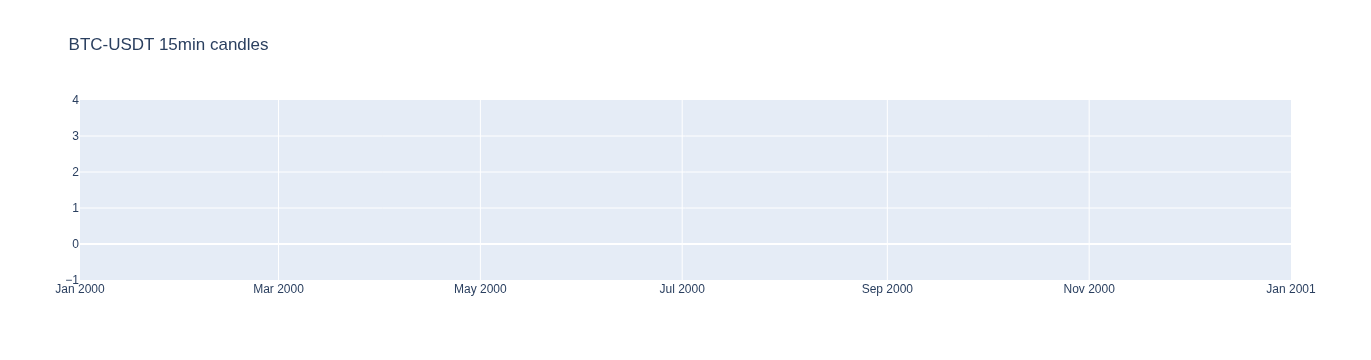

In [13]:
PlotTool.plot_candles(df_candles_1min.tail(1000), target_period, ticker)

### Train test split

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.base import BaseEstimator, TransformerMixin

def create_pipe(x, y) -> (Pipeline, Pipeline):
    """ Create feature only pipeline to use for transform and inverse transform """

    time_cols = [col for col in x.columns if col.startswith("time")]
    float_cols = list(set(x.columns) - set(time_cols))
    x_pipe = Pipeline(
        [("xscaler", ColumnTransformer([("xrs", StandardScaler(), float_cols)], remainder="passthrough")),
         ("xmms", MaxAbsScaler())])
    x_pipe.fit(x)

    class AddTwo(BaseEstimator, TransformerMixin):
        def fit(self, X, y=None):
            return self
        
        def transform(self, X):
            # Adding 2 to every value in the dataset
            return X + 2    
        def inverse_transform(self, X):
            return X - 2

    y_pipe = make_pipeline(AddTwo())
    return x_pipe, y_pipe


In [15]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

def train_test_split(x, y, test_days=14):
    """ In addition to train_test_split, create pipeline for reverse transform in future"""
    test_index = max(x.index) - pd.Timedelta(days=test_days)
    is_test = (x.index >= test_index)
    is_train = (x.index < test_index)
    
    x_train, y_train, x_test, y_test = x[is_train], y[is_train], \
        x[is_test], y[is_test]

    # Create pipeline to transform/reverse transform
    x_pipe, y_pipe = create_pipe(x_train, y_train)
    return x_pipe, y_pipe, x_train, y_train, x_test, y_test


x_pipe, y_pipe, x_train, y_train, x_test, y_test = train_test_split(features, targets, test_days=test_days)

## Model creation and training

### Create model

In [16]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

model_name='SignalClassifierLgb'
import mlflow
from mlflow import MlflowClient

#mlflow.set_tracking_uri('http://localhost:5000')
#mlflow_client = MlflowClient()

def create_model_lgb(lgb_params):
    """ LGB classifier. """

# Initialize with multi-class parameters
    model = LGBMClassifier(
        objective='multiclass',
        num_class=3,
        num_leaves=31,
        learning_rate=0.05,
        n_estimators=100,
        random_state=42
    )   
    print(f'Created new model {model}')
    return model

def ensure_model(model_name):
    mlflow_client = MlflowClient()
    versions = mlflow_client.search_model_versions(f"name='{model_name}'")

    if versions:
        version = versions[-1]
        model = mlflow.sklearn.load_model(versions[-1].source)
        model_url = f'models:/{model_name}/{version.version}'
    else:
        model = create_model()
        model_url = None
    return model, model_url

#model, model_url = ensure_model(model_name)
#print(model_url)
model = create_model_lgb(lgb_params)


Created new model LGBMClassifier(learning_rate=0.05, num_class=3, objective='multiclass',
               random_state=42)


### Fit, predict

In [17]:
model.fit(x_pipe.transform(x_train), y_pipe.transform(y_train.values.ravel()), feature_name = x_train.columns.tolist())
# Predict and inverse transform to dataframe
y_pred = model.predict(x_pipe.transform(x_test))
y_pred = y_pipe.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred, columns = y_test.columns, index = y_test.index)
y_pred.tail()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27447
[LightGBM] [Info] Number of data points in the train set: 38021, number of used features: 110
[LightGBM] [Info] Start training from score -2.269754
[LightGBM] [Info] Start training from score -0.250094
[LightGBM] [Info] Start training from score -2.137623


/home/dima/projects/pytrade2-analytics/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



signal
close_time                 
2025-05-11 19:36:00       0
2025-05-11 19:37:00       0
2025-05-11 19:38:00       0
2025-05-11 19:39:00       0
2025-05-11 19:40:00       0

In [18]:
y_pred[y_pred["signal"] != 0].tail()


signal
close_time                 
2025-05-11 18:32:00       1
2025-05-11 18:33:00       1
2025-05-11 18:34:00       1
2025-05-11 18:35:00       1
2025-05-11 18:36:00       1

In [19]:
x_test.tail()

time_hour  time_minute  ichimoku_base_line_10min_diff  ichimoku_conversion_line_10min_diff  ichimoku_a_10min_diff  ichimoku_b_10min_diff  cci_10min_diff  adx_10min_diff  rsi_10min_diff  stoch_10min_diff  macd_10min_diff  ichimoku_base_line_15min_diff  ichimoku_conversion_line_15min_diff  ichimoku_a_15min_diff  ichimoku_b_15min_diff  cci_15min_diff  adx_15min_diff  rsi_15min_diff  stoch_15min_diff  macd_15min_diff  ichimoku_base_line_25min_diff  ichimoku_conversion_line_25min_diff  ichimoku_a_25min_diff  ichimoku_b_25min_diff  cci_25min_diff  adx_25min_diff  rsi_25min_diff  stoch_25min_diff  macd_25min_diff  ichimoku_base_line_40min_diff  ichimoku_conversion_line_40min_diff  ichimoku_a_40min_diff  ichimoku_b_40min_diff  cci_40min_diff  adx_40min_diff  rsi_40min_diff  stoch_40min_diff  macd_40min_diff  ichimoku_base_line_50min_diff  ichimoku_conversion_line_50min_diff  ichimoku_a_50min_diff  ichimoku_b_50min_diff  cci_50min_diff  adx_50min_diff  rsi_50min_diff  stoch_50min_diff  macd_50min_diff  ichimoku_base_line_60min_diff  ichimoku_conversion_line_60min_diff  ichimoku_a_60min_diff  ichimoku_b_60min_diff  cci_60min_diff  adx_60min_diff  rsi_60min_diff  stoch_60min_diff  macd_60min_diff  l2_ichimoku_base_line_10min_diff  l2_ichimoku_conversion_line_10min_diff  l2_ichimoku_a_10min_diff  l2_ichimoku_b_10min_diff  l2_cci_10min_diff  l2_adx_10min_diff  l2_rsi_10min_diff  l2_stoch_10min_diff  l2_macd_10min_diff  l2_ichimoku_base_line_15min_diff  l2_ichimoku_conversion_line_15min_diff  l2_ichimoku_a_15min_diff  l2_ichimoku_b_15min_diff  l2_cci_15min_diff  l2_adx_15min_diff  l2_rsi_15min_diff  l2_stoch_15min_diff  l2_macd_15min_diff  l2_ichimoku_base_line_25min_diff  l2_ichimoku_conversion_line_25min_diff  l2_ichimoku_a_25min_diff  l2_ichimoku_b_25min_diff  l2_cci_25min_diff  l2_adx_25min_diff  l2_rsi_25min_diff  l2_stoch_25min_diff  l2_macd_25min_diff  l2_ichimoku_base_line_40min_diff  l2_ichimoku_conversion_line_40min_diff  l2_ichimoku_a_40min_diff  l2_ichimoku_b_40min_diff  l2_cci_40min_diff  l2_adx_40min_diff  l2_rsi_40min_diff  l2_stoch_40min_diff  l2_macd_40min_diff  l2_ichimoku_base_line_50min_diff  l2_ichimoku_conversion_line_50min_diff  l2_ichimoku_a_50min_diff  l2_ichimoku_b_50min_diff  l2_cci_50min_diff  l2_adx_50min_diff  l2_rsi_50min_diff  l2_stoch_50min_diff  l2_macd_50min_diff  l2_ichimoku_base_line_60min_diff  l2_ichimoku_conversion_line_60min_diff  l2_ichimoku_a_60min_diff  l2_ichimoku_b_60min_diff  l2_cci_60min_diff  l2_adx_60min_diff  l2_rsi_60min_diff  l2_stoch_60min_diff  l2_macd_60min_diff
close_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

# Evaluate the model

### Trading emulation

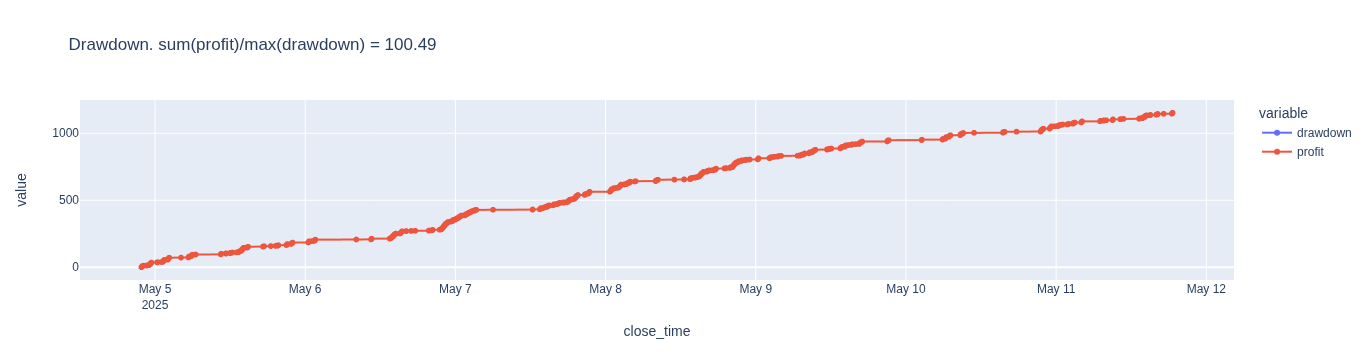

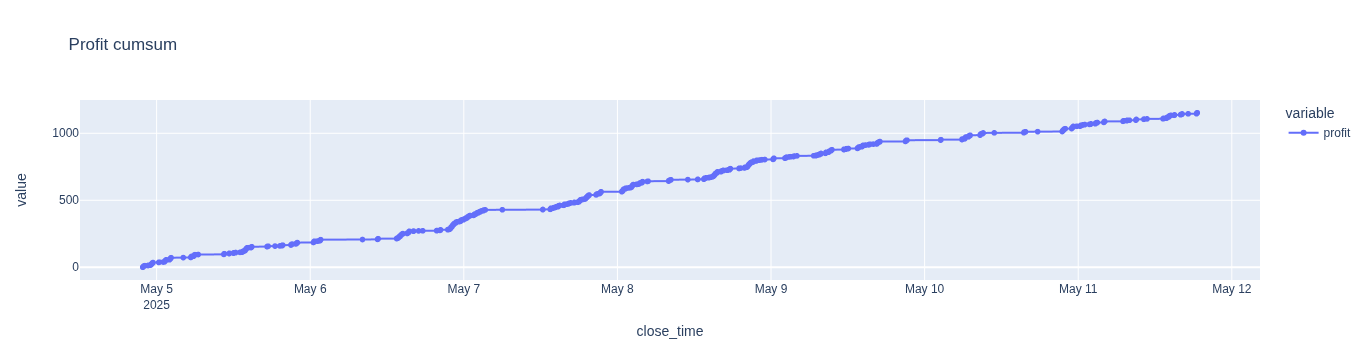

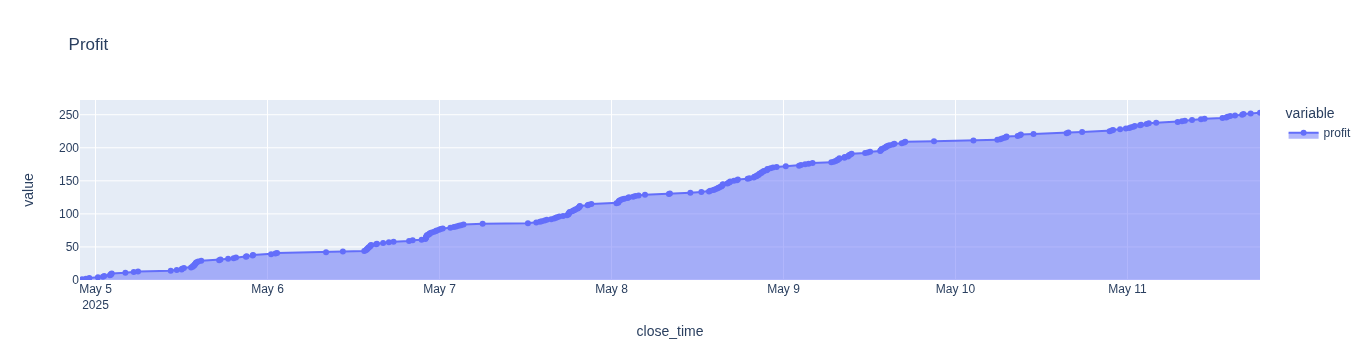

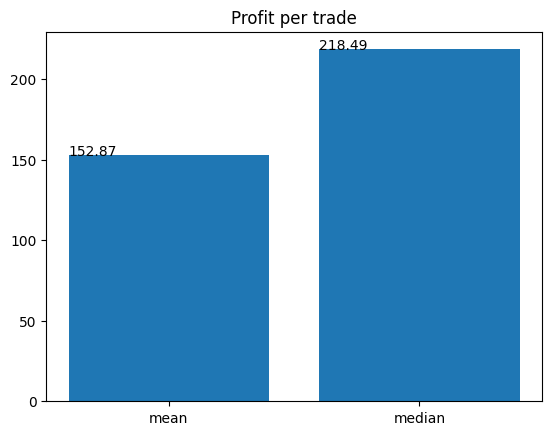

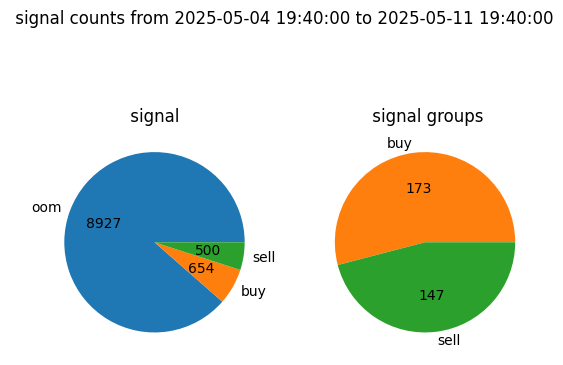

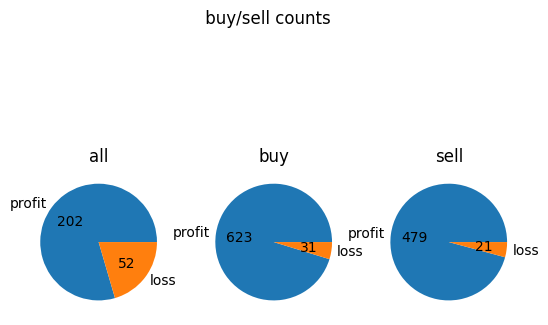

In [20]:
from pytrade2.pytrade2.strategy.signal.SignalByFutLowHigh import SignalByFutLowHigh
import seaborn as sns
import plotly as py
import plotly.express as px


def calc_trade_df(y_test, y_pred, candles_1min, stop_loss_coeff, take_profit_ratio):
    """ Using predicted values, create dataframe with signal, profit, drawdown """
    trade_df = with_profit(y_test, y_pred, candles_1min, stop_loss_coeff, take_profit_ratio)
    trade_df = with_drawdown(trade_df)
    return trade_df

def with_profit(y_test, y_pred, candles_1min, stop_loss_coeff, take_profit_ratio):
    """ Set signal[profit] to positive profit or negative loss """
    trade_df = pd.DataFrame(index = y_pred.index)
    trade_df[['close', 'high', 'low']] = candles_1min[['close', 'high', 'low']]
    trade_df['signal'] = y_pred['signal']
    trade_df['profit'] = 0
    i_trade_opened = None
    
    
    def close_trade(i_trade_opened, i_trade_closed, profit):
        """ Close current trade, set profit, consider double comission: open and close """
        trade_df.at[i_trade_opened, "profit"] = \
            profit \
            - trade_df.at[i_trade_opened, 'close'] * comission \
            - trade_df.at[i_trade_closed, 'close'] * comission
    
    for i in trade_df.index:
        if i_trade_opened:
           # Check opened buy or sell  position
            trade_open_price = trade_df.at[i_trade_opened, "close"]
            trade_stop_loss = trade_open_price * stop_loss_coeff
            trade_take_profit = trade_stop_loss * take_profit_ratio
            trade_direction = trade_df.at[i_trade_opened, "signal"]
            if trade_direction > 0:
                profit = trade_df.at[i, "high"] - trade_open_price
                loss = trade_open_price - trade_df.at[i, "low"]
            elif trade_direction < 0:
                profit = trade_open_price - trade_df.at[i, "low"]
                loss = trade_df.at[i, "high"] - trade_open_price
            else:
                profit = loss = 0
            if loss >= trade_stop_loss:
                # Close trade, stop loss
                close_trade(i_trade_opened, i, -trade_stop_loss)
                #trade_df.at[i_trade_opened, "profit"] = -trade_stop_loss
                i_trade_opened = None
            elif profit >= trade_take_profit:
                # Close trade, take profit
                close_trade(i_trade_opened, i, trade_take_profit)
                i_trade_opened = None
        elif trade_df.at[i, "signal"] != 0:
            # Buy or sell
            i_trade_opened = i
    return trade_df[['signal', 'profit']]
            
def with_drawdown(df):
    # todo: remove -10
    #profits = df.loc[df['profit'] != 0, 'profit'][:-10]
    profits = df['profit']
    max_drawdown = 0
    cur_drawdown = 0
    drawdowns = []
        
    for profit in profits.values:
        if profit < 0:
            # Loss - increase drawdown
            cur_drawdown -= profit # increase drawdown
        else:
            # We have profit! Decrease drowdown, or if profit covered previous drawdown, set drawdown to 0.
            cur_drawdown = max(0, cur_drawdown - profit)
        max_drawdown = max(max_drawdown, cur_drawdown)
        drawdowns.append(cur_drawdown)

    df['drawdown'] = drawdowns
    return df

def plot_drawdown(signal_ext):
    drawdown = max(signal_ext['drawdown'])
    profit = sum(signal_ext['profit'])
    ratio = round(profit/drawdown, 2) if drawdown > 0 else 'infinity'
    title = f'Drawdown. sum(profit)/max(drawdown) = {ratio}'
    px.line(signal_ext.loc[signal_ext['signal']!=0, ['drawdown', 'profit']], title = title).update_traces(mode='lines+markers').show()

def barplot_profit(signal_ext):
    profit_df = signal_ext.loc[signal_ext['profit']!=0, 'profit']
    mean = profit_df.mean()
    median = profit_df.median()
    
    bars = plt.bar(x=["mean", "median"], height=[mean, median])
    for bar in bars:
        yval = round(bar.get_height(), 2)
        plt.text(bar.get_x(), yval + .005, yval)
    
    plt.title('Profit per trade');
    plt.show()

    #sns.barplot(x=["mean", "median1"], y=[mean, median]);

def plot_trade_eda():
    # # Drawdown plot
    plot_drawdown(signal_ext)
    
    # # Profit cumsumplot
    px.line(signal_ext.loc[signal_ext['signal']!=0, 'profit'].cumsum(), title = 'Profit cumsum').update_traces(mode='lines+markers').show()
    #px.line(signal_ext.loc[signal_ext['signal']!=0, 'profit'], title = f'Profit').update_traces(mode='lines+markers').show()
    px.line(signal_ext.loc[signal_ext['profit']!=0, 'profit'], title = f'Profit').update_traces(mode='lines+markers', fill='tozeroy').show()
    barplot_profit(signal_ext)
    
    # # Pie plots
    PlotTool.plot_signal_counts(signal_ext)
    PlotTool.plot_buy_sell(signal_ext)    

signal_ext = calc_trade_df(y_test, y_pred, df_candles_1min, stop_loss_coeff, profit_loss_ratio)

plot_trade_eda()



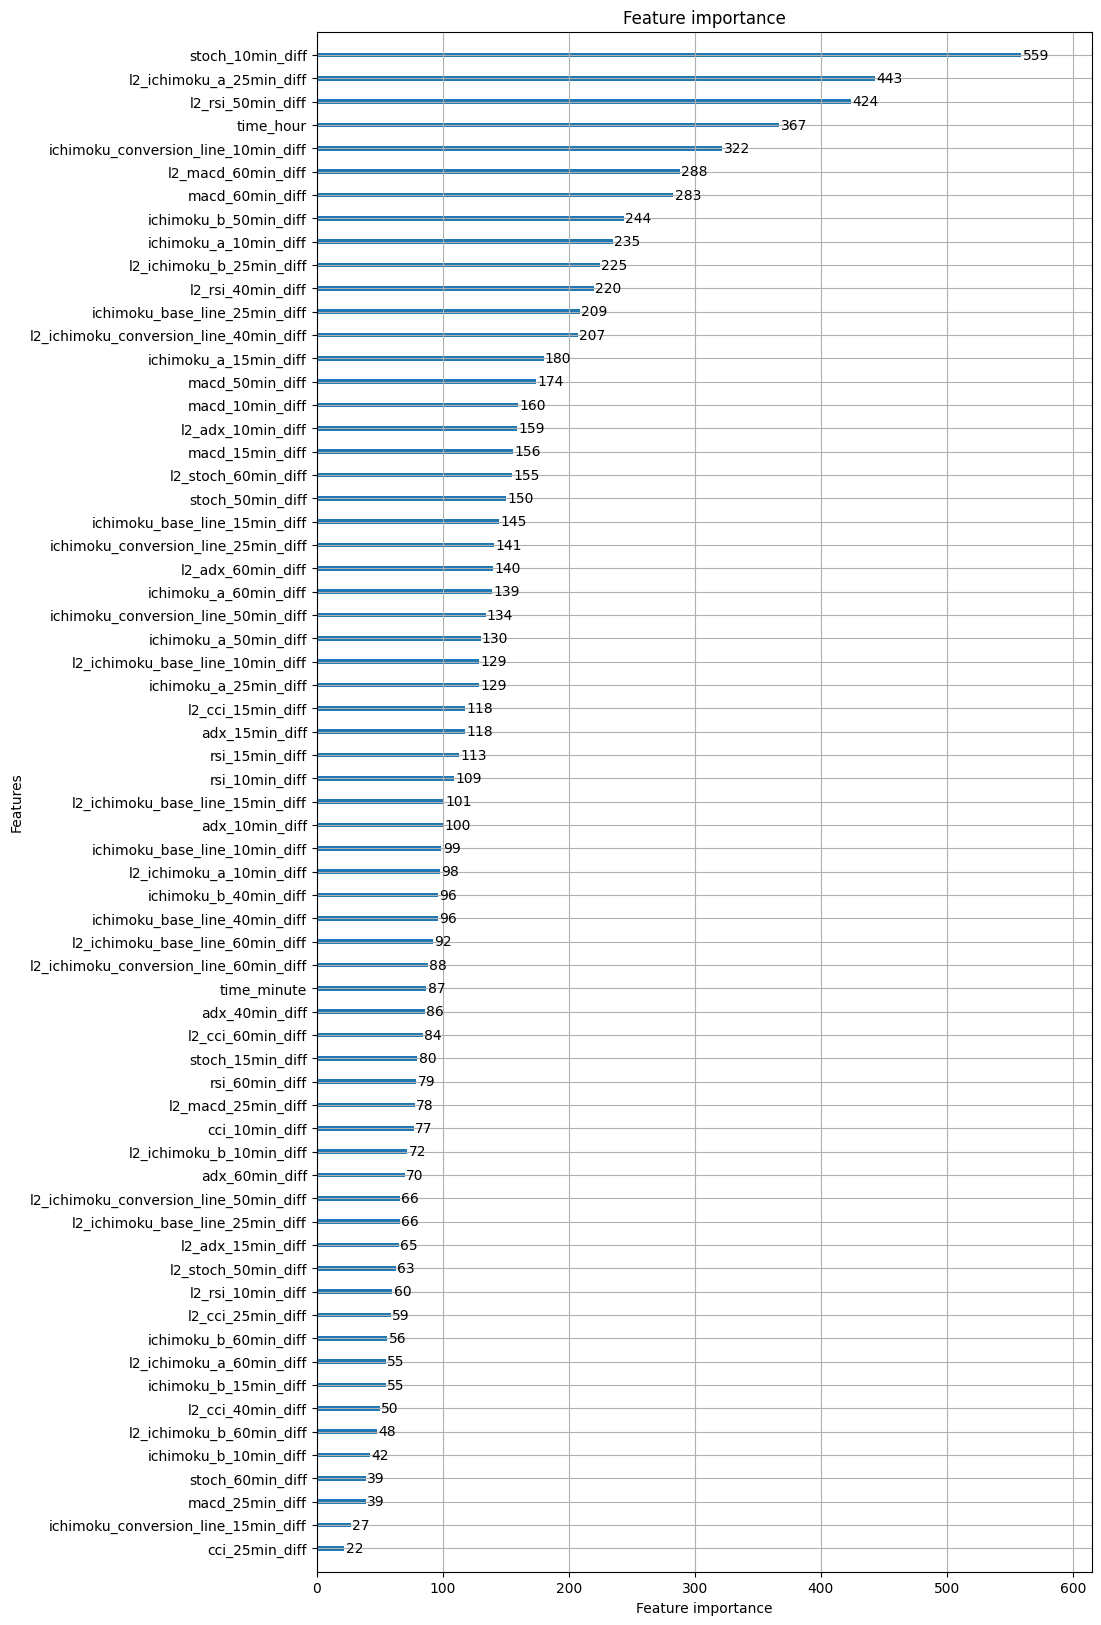

In [21]:
def plot_importance():
    
    lgb.plot_importance(model,  figsize=(10, 20))
    plt.show()
plot_importance()

## MLFlow experiment

In [22]:
y_test.info()
y_pred.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10081 entries, 2025-05-04 19:40:00 to 2025-05-11 19:40:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   signal  10081 non-null  int64
dtypes: int64(1)
memory usage: 415.6 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10081 entries, 2025-05-04 19:40:00 to 2025-05-11 19:40:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   signal  10081 non-null  int64
dtypes: int64(1)
memory usage: 415.6 KB


In [23]:
def calc_metrics():
    """ Metrics to use for evaluation """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    profit_mean = signal_ext.loc[signal_ext['signal'] != 0, 'profit'].mean()
    profit_median = signal_ext.loc[signal_ext['signal'] != 0, 'profit'].median()
    profit_drawdown_ratio = sum(signal_ext['profit'])/max(signal_ext['drawdown'])

    return {
        'profit_drawdown_ratio': profit_drawdown_ratio,
        'profit_mean': profit_mean,
            'profit_median': profit_median,
            "mae": mae, 
            "mse": mse, 
            "rmse": rmse, 
            "r2": r2}

In [24]:
import mlflow
from mlflow import MlflowClient

#mlflow.set_tracking_uri('http://localhost:5000')
#mlflow_client = MlflowClient()

# def new_experiment(mflow_client, experiment_name):
#     print(f'Creating new mlflow experiment {experiment_name}')
#     experiment_tags = {'project_name': 'trade-bots-farm'}
#     artifact_location='s3://trade-bots-farm/mlartifacts'
#     experiment = mlflow_client.create_experiment(
#         name=experiment_name, tags=experiment_tags, artifact_location=artifact_location
#     )    
#     return experiment

# def ensure_experiment(mlflow_client, experiment_name):
#     experiments = mlflow_client.search_experiments(filter_string=f"name = '{experiment_name}' AND tags.project_name='trade-bots-farm'")
#     if not experiments:
#         experiment = new_experiment(mlflow_client, experiment_name)
#     else:
#         experiment = experiments[-1]
#     return experiment


In [25]:
# import numpy as np
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from datetime import datetime

# if do_log_experiment:
#     print('Logging experiment')
#     experiment = ensure_experiment(mlflow_client, experiment_name)
#     mlflow.set_experiment(experiment_name)
    
#     metrics = calc_metrics()
#     #print(metrics)
#     #run_name = f'{experiment_name}_{datetime.now()}'
    
#     params = {
#         # "n_estimators": 100,
#         # "max_depth": 6,
#         # "min_samples_split": 10,
#         # "min_samples_leaf": 4,
#         # "bootstrap": True,
#         # "oob_score": False,
#         # "random_state": 888,
    
#         'train_size_rows': len(x_train),
#         'history_days': history_days,
#         'test_days': test_days,
#         'profit_loss_ratio':  profit_loss_ratio,
#         'stop_loss_coeff': stop_loss_coeff,
#         'stop_loss_add_ratio': stop_loss_add_ratio,
#         'comission_pct': comission_pct,
#         'features_candles_periods': features_candles_periods,
#         'target_period': target_period
#     }
    
    
#     # Initiate the MLflow run context
#     import inspect
#     print(inspect.signature(mlflow.sklearn.log_model))
#     with mlflow.start_run(run_name = run_name) as run:
#         #mlflow.set_tags({'tag': 'val'})
#         # Log the parameters used for the model fit
#         mlflow.log_params(params)
    
#         # Log the error metrics that were calculated during validation
#         mlflow.log_metrics(metrics)
    
#         if do_log_model:
#             # Log an instance of the trained model for later use
#             artifact_path = run_name
#             mlflow.sklearn.log_model(
#                 sk_model=model, 
#                 input_example=x_test,
#                 artifact_path=artifact_path,
#                 registered_model_name=model_name
#             )

#             # Set trade ready flag
#             if is_trade_ready:
#                 # set extra tags on the model
#                 model_info = mlflow_client.get_latest_versions(model_name)[0]
#                 print(f'Setting model {model_name} v{model_info.version} is_trade_ready={is_trade_ready}')
#                 mlflow_client.set_model_version_tag(
#                     name=model_name,
#                     version=model_info.version,
#                     key='is_trade_ready',
#                     value=is_trade_ready
#                 )            


In [29]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
params = {
    # "n_estimators": 100,
    # "max_depth": 6,
    # "min_samples_split": 10,
    # "min_samples_leaf": 4,
    # "bootstrap": True,
    # "oob_score": False,
    # "random_state": 888,

    'train_size_rows': len(x_train),
    'history_days': history_days,
    'test_days': test_days,
    'profit_loss_ratio':  profit_loss_ratio,
    'stop_loss_coeff': stop_loss_coeff,
    'stop_loss_add_ratio': stop_loss_add_ratio,
    'comission_pct': comission_pct,
    'features_candles_periods': features_candles_periods,
    'target_period': target_period
}
metrics = calc_metrics()    
print(f'Params are: {params}\nMetrics are:{metrics}')

Params are: {'train_size_rows': 38021, 'history_days': 40, 'test_days': 7, 'profit_loss_ratio': 2.5, 'stop_loss_coeff': 0.001, 'stop_loss_add_ratio': 0, 'comission_pct': 0.012, 'features_candles_periods': ['10min', '15min', '25min', '40min', '50min', '60min'], 'target_period': '15min'}
Metrics are:{'profit_drawdown_ratio': 100.49004120260206, 'profit_mean': np.float64(33.64760715424611), 'profit_median': np.float64(0.0), 'mae': 0.15841682372780477, 'mse': 0.15921039579406804, 'rmse': np.float64(0.39901177400431187), 'r2': 0.20159183196128572}


In [40]:
class MlflowTool:
    """ Log experiment, model, x pipe, y pipe to mlflow """
    
    def __init__(self, project_name = 'trade-bots-farm', artifact_location = 's3://trade-bots-farm/mlartifacts'):
        self.project_name = project_name
        self.artifact_location = artifact_location
        self.mlflow_client = MlflowClient()
        
    def new_experiment(self, experiment_name):
        print(f'Creating new mlflow experiment {experiment_name}')
        experiment_tags = {'project_name': self.project_name}
        artifact_location=self.artifact_location
        experiment = self.mlflow_client.create_experiment(
            name=experiment_name, tags=experiment_tags, artifact_location=artifact_location
        )    
        return experiment
    
    def ensure_experiment(self, experiment_name):
        #experiments = self.mlflow_client.search_experiments(filter_string=f"name='{experiment_name}' AND tags.project_name='{self.project_name}'")
        experiments = self.mlflow_client.search_experiments(filter_string=f"name='{experiment_name}'")
        if not experiments:
            experiment = self.new_experiment(experiment_name)
        else:
            experiment = experiments[-1]
        return experiment    

    def set_trade_ready_tag(self, model_name):
        
        model_info = self.mlflow_client.get_latest_versions(model_name)[0]
        print(f'Setting model {model_name} v{model_info.version} is_trade_ready={is_trade_ready}')
        self.mlflow_client.set_model_version_tag(
            name=model_name,
            version=model_info.version,
            key='is_trade_ready',
            value=True)        
        
    def log_model_like(self, model, model_name, input_example = None, is_trade_ready = False):
        """ Log model or x_pipe or y_pipe """
        current_run = mlflow.active_run()
        run_name = current_run.data.tags["mlflow.runName"]
        artifact_path = f"{run_name} {model_name}"
        print(f'Log model {model} or pipeline to mlflow, artifact_path:{artifact_path}, model_name:{model_name}, is_trade_ready:{is_trade_ready}')
        mlflow.sklearn.log_model(
            sk_model=model, 
            input_example=x_test,
            #artifact_path=artifact_path,
            registered_model_name=model_name
            )
        print("logged model")
        # Set trade ready flag
        if is_trade_ready:
            self.set_trade_ready_tag(model_name)
                
    def log_experiment_ext(self, experiment_name, run_name, params, metrics, model_name, model, x_pipe, y_pipe, x_example, y_example, is_trade_ready):
        
        print(f'Logging experiment.\nParams:{params}\nMetrics:{metrics}')
        #mlflow_client = MlflowClient()
        experiment = self.ensure_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
        
        # Initiate the MLflow run context
        import inspect
        print(inspect.signature(mlflow.sklearn.log_model))
        with mlflow.start_run(run_name = run_name) as run:
            #mlflow.set_tags({'tag': 'val'})
            # Log the parameters used for the model fit
            mlflow.log_params(params)
        
            # Log the error metrics that were calculated during validation
            mlflow.log_metrics(metrics)
        
            if model:
                self.log_model_like(model, model_name, None, is_trade_ready)
            if x_pipe:
                self.log_model_like(x_pipe, f'{model_name}_x_pipe', x_example, is_trade_ready)
            if y_pipe:
                self.log_model_like(y_pipe, f'{model_name}_y_pipe', y_example, is_trade_ready)

#%reload_ext dotenv
#%dotenv
#MlflowTool().log_experiment_ext(experiment_name, run_name, params, metrics, model_name, model, x_pipe, y_pipe, x_test, y_test, is_trade_ready)
is_trade_ready = True
print(model_name)
MlflowTool().log_experiment_ext(experiment_name, run_name, params, metrics, model_name, model, x_pipe, y_pipe, x_test, y_test, is_trade_ready)


SignalClassifierLgb
Logging experiment.
Params:{'train_size_rows': 38021, 'history_days': 40, 'test_days': 7, 'profit_loss_ratio': 2.5, 'stop_loss_coeff': 0.001, 'stop_loss_add_ratio': 0, 'comission_pct': 0.012, 'features_candles_periods': ['10min', '15min', '25min', '40min', '50min', '60min'], 'target_period': '15min'}
Metrics:{'profit_drawdown_ratio': 100.49004120260206, 'profit_mean': np.float64(33.64760715424611), 'profit_median': np.float64(0.0), 'mae': 0.15841682372780477, 'mse': 0.15921039579406804, 'rmse': np.float64(0.39901177400431187), 'r2': 0.20159183196128572}
(sk_model, artifact_path: Optional[str] = None, conda_env=None, code_paths=None, serialization_format='cloudpickle', registered_model_name=None, signature: mlflow.models.signature.ModelSignature = None, input_example: Union[pandas.core.frame.DataFrame, numpy.ndarray, dict, list, ForwardRef('csr_matrix'), ForwardRef('csc_matrix'), str, bytes, tuple] = None, await_registration_for=300, pip_requirements=None, extra_pip_

/home/dima/projects/pytrade2-analytics/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

/home/dima/projects/pytrade2-analytics/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If yo

logged model
Setting model SignalClassifierLgb v11 is_trade_ready=True
Log model Pipeline(steps=[('xscaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('xrs', StandardScaler(),
                                                  ['rsi_25min_diff',
                                                   'adx_50min_diff',
                                                   'stoch_50min_diff',
                                                   'l2_adx_25min_diff',
                                                   'macd_60min_diff',
                                                   'ichimoku_b_15min_diff',
                                                   'l2_ichimoku_b_50min_diff',
                                                   'l2_ichimoku_base_line_15min_diff',
                                                   'cci_40min_diff',
                                                   'l2_macd_50min_diff',
                     

/home/dima/projects/pytrade2-analytics/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

2025/06/25 12:23:45 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("This 'Pipeline' has no attribute 'predict'"). To see the full traceback, set the logging lev

logged model
Setting model SignalClassifierLgb_x_pipe v8 is_trade_ready=True
Log model Pipeline(steps=[('addtwo', AddTwo())]) or pipeline to mlflow, artifact_path:SignalClassification target: 15min, sharp: 2.5, periods:['10min', '15min', '25min', '40min', '50min', '60min'],  history 40, test 7, stop loss coeff 0.001 SignalClassifierLgb_y_pipe, model_name:SignalClassifierLgb_y_pipe, is_trade_ready:True


/home/dima/projects/pytrade2-analytics/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

2025/06/25 12:23:59 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("This 'Pipeline' has no attribute 'predict'"). To see the full traceback, set the logging lev

logged model
Setting model SignalClassifierLgb_y_pipe v8 is_trade_ready=True
🏃 View run SignalClassification target: 15min, sharp: 2.5, periods:['10min', '15min', '25min', '40min', '50min', '60min'],  history 40, test 7, stop loss coeff 0.001 at: http://192.168.49.2:30180/#/experiments/1/runs/1f05d17a41da4639b5dd072864247d33
🧪 View experiment at: http://192.168.49.2:30180/#/experiments/1
